In [1]:
import numpy as np
import paddle
from matplotlib import pyplot as plt
from IPython import display as ipd
import soundfile as sf
import librosa.display
paddle.set_device("gpu:5")
import sys
sys.path.append("/home/chenfeiyu/projects/Parakeet_0.2/")

In [8]:
%matplotlib inline

## 加载模型

In [11]:
from examples.ge2e.audio_processor import SpeakerVerificationPreprocessor
from parakeet.models.lstm_speaker_encoder import LSTMSpeakerEncoder

# speaker encoder
p = SpeakerVerificationPreprocessor(sampling_rate=16000, audio_norm_target_dBFS=-30, vad_window_length=30, vad_moving_average_width=8, vad_max_silence_length=6, 
                                   mel_window_length=25, mel_window_step=10, n_mels=40, partial_n_frames=160, min_pad_coverage=0.75, partial_overlap_ratio=0.5)
speaker_encoder = LSTMSpeakerEncoder(n_mels=40, num_layers=3, hidden_size=256, output_size=256)
speaker_encoder_params_path = "/home/chenfeiyu/projects/Parakeet_0.2/examples/ge2e/runs/cn/checkpoints/step-3000000.pdparams"
speaker_encoder.set_state_dict(paddle.load(speaker_encoder_params_path))
speaker_encoder.eval()

# synthesizer
from parakeet.models.tacotron2 import Tacotron2
from examples.tacotron2_aishell3.chinese_g2p import convert_sentence
from examples.tacotron2_aishell3.aishell3 import voc_phones, voc_tones

from yacs.config import CfgNode
synthesizer = Tacotron2(
    vocab_size=70,
    n_tones=10,
    d_mels= 80,
    d_encoder= 512,
    encoder_conv_layers = 3,
    encoder_kernel_size= 5,
    d_prenet= 256,
    d_attention_rnn= 1024,
    d_decoder_rnn = 1024,
    attention_filters = 32,
    attention_kernel_size = 31,
    d_attention= 128,
    d_postnet = 512,
    postnet_kernel_size = 5,
    postnet_conv_layers = 5,
    reduction_factor = 1,
    p_encoder_dropout = 0.5,
    p_prenet_dropout= 0.5,
    p_attention_dropout= 0.1,
    p_decoder_dropout= 0.1,
    p_postnet_dropout= 0.5,
    d_global_condition=256,
)
params_path = "/home/chenfeiyu/projects/Parakeet_0.2/examples/tacotron2_aishell3/runs/debug/checkpoints/step-55000.pdparams"
synthesizer.set_state_dict(paddle.load(params_path))
synthesizer.eval()

# vocoder
from parakeet.models import ConditionalWaveFlow
vocoder = ConditionalWaveFlow(upsample_factors=[16, 16], n_flows=8, n_layers=8, n_group=16, channels=128, n_mels=80, kernel_size=[3, 3])
params_path = "/home/chenfeiyu/projects/parakeet_examples/waveflow/step-2000000.pdparams"
vocoder.set_state_dict(paddle.load(params_path))
vocoder.eval()

## 生成 speaker encoding

In [18]:
# ref_audio_path = "/home/chenfeiyu/datasets/aishell3/train/wav/SSB0011/SSB00110001.wav"
ref_name = "女声2.wav"
ref_audio_path = f"./ref_audio/{ref_name}"
ipd.Audio(ref_audio_path, normalize=True)

In [19]:
mel_sequences = p.extract_mel_partials(p.preprocess_wav(ref_audio_path))
print("mel_sequences: ", mel_sequences.shape)
with paddle.no_grad():
    embed = speaker_encoder.embed_utterance(paddle.to_tensor(mel_sequences))
print("embed shape: ", embed.shape)

mel_sequences:  (2, 160, 40)
embed shape:  [256]


## 合成频谱

In [20]:
sentence = "语音的表现形式%在未来%将变得越来越重要$"
phones, tones = convert_sentence(sentence)
print(phones)
print(tones)

phones = np.array([voc_phones.lookup(item) for item in phones], dtype=np.int64)
tones = np.array([voc_tones.lookup(item) for item in tones], dtype=np.int64)

phones = paddle.to_tensor(phones).unsqueeze(0)
tones = paddle.to_tensor(tones).unsqueeze(0)
utterance_embeds = paddle.unsqueeze(embed, 0)

['v', 'ien', 'd', 'e', 'b', 'iao', 'x', 'ian', 'x', 'ieng', 'sh', 'iii', '%', 'z', 'ai', 'uei', 'l', 'ai', '%', 'j', 'iang', 'b', 'ian', 'd', 'e', 've', 'l', 'ai', 've', 'zh', 'ueng', 'iao', '$']
['3', '1', '0', '5', '0', '3', '0', '4', '0', '2', '0', '4', '0', '0', '4', '4', '0', '2', '0', '0', '1', '0', '4', '0', '2', '4', '0', '2', '4', '0', '4', '4', '0']


 35%|███▍      | 349/1000 [00:01<00:02, 233.91it/s]

content exhausted!


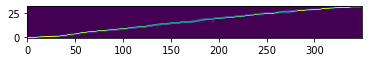

In [21]:
outputs = synthesizer.infer(phones, tones=tones, global_condition=utterance_embeds)
mel_input = paddle.transpose(outputs["mel_outputs_postnet"], [0, 2, 1])
plt.imshow(outputs["alignments"][0].numpy().T, origin="lower")

## 合成语音

time: 12.234672784805298s


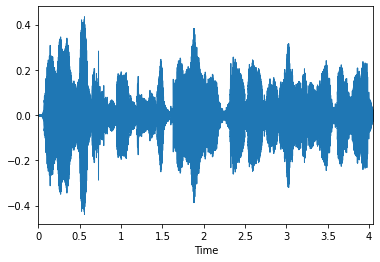

In [22]:
with paddle.no_grad():
    wav = vocoder.infer(mel_input)
wav = wav.numpy()[0]
sf.write(f"syn_audio/{ref_name}", wav, samplerate=22050)
librosa.display.waveplot(wav)

In [23]:
ipd.Audio(wav, rate=22050)